### **Train and Deploy a CNN Model Using TensorFlow Serving**

**Convolutional autodecoder is used here for denoising the images**

In [1]:
import glob
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.metrics import Precision
from keras.metrics import Recall
from keras.metrics import categorical_crossentropy
from keras import layers
import numpy as np
import pandas as pd


### **Loading and Augmenting the dataset**

In [2]:
img_path = glob.glob(r'C:\Users\henis\OneDrive\Pictures\Screenshots\OneDrive\Desktop\AL_ML_Classnotes\ADL\Train_deploy_project\train_deploy_dataset\dataset\*.*')

data = []

for i in img_path:
   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (128,128))
    image=np.array(image)
    data.append(image)
data = np.array(data)   

labels = pd.read_csv(r'C:\Users\henis\OneDrive\Pictures\Screenshots\OneDrive\Desktop\AL_ML_Classnotes\ADL\Train_deploy_project\train_deploy_dataset\trainLabels.csv')
label = labels['level']
label = np.array(label)
label = pd.get_dummies(label).values


### **Splitting the dataset**

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2,
                                                random_state=43, shuffle=True )


### **preprocess the dataset to correct for noise and under and over exposure**
**Adding random noise to each image in the supplied array**

In [4]:
noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

### **Defining the distributed training strategy**

In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


## **Define a CNN architecture to extract features from the model data**
### **We use Convolutional autoencoder for image denoising**

In [6]:
from keras.callbacks import ModelCheckpoint
input_img = keras.Input(shape=(128,128,3))

with strategy.scope():
# Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    # Autoencoder
    autoencoder = keras.Model(input_img, x)
    
    autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 32)        18464 

### **Defining loss, optimizer, epochs, learning rate, and evaluation metric**

In [7]:
from keras import losses,optimizers
from keras import metrics
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.BinaryCrossentropy(),metrics = 'accuracy')

**Defining checkpoint**

In [8]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('train_deploy.h5',save_best_only=True)

In [9]:
history = autoencoder.fit(x_train_noisy, X_train,
                    epochs=10,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, X_test),
                         callbacks=[checkpoint])
autoencoder.save('train_deploy.keras') #Saving the model

Epoch 1/10
9/9 [==============================] - 53s 6s/step - loss: -7.8013 - accuracy: 0.3919 - val_loss: -37.9663 - val_accuracy: 0.4962
Epoch 2/10


C:\Users\henis\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 52s 6s/step - loss: -208.8014 - accuracy: 0.5428 - val_loss: -712.1861 - val_accuracy: 0.5958
Epoch 3/10
9/9 [==============================] - 53s 6s/step - loss: -2624.9497 - accuracy: 0.6044 - val_loss: -7043.1924 - val_accuracy: 0.5875
Epoch 4/10
9/9 [==============================] - 45s 5s/step - loss: -19754.5527 - accuracy: 0.5562 - val_loss: -45760.9727 - val_accuracy: 0.5445
Epoch 5/10
9/9 [==============================] - 46s 5s/step - loss: -104673.4688 - accuracy: 0.5257 - val_loss: -216236.1406 - val_accuracy: 0.4940
Epoch 6/10
9/9 [==============================] - 51s 6s/step - loss: -431575.6562 - accuracy: 0.5184 - val_loss: -803019.4375 - val_accuracy: 0.5266
Epoch 7/10
9/9 [==============================] - 50s 6s/step - loss: -1451710.7500 - accuracy: 0.4965 - val_loss: -2482684.7500 - val_accuracy: 0.4933
Epoch 8/10
9/9 [==============================] - 55s 6s/step - loss: -4128043.7500 - accuracy: 0.4946 - val_loss: -66427

### **Plotting model loss and accuracy**

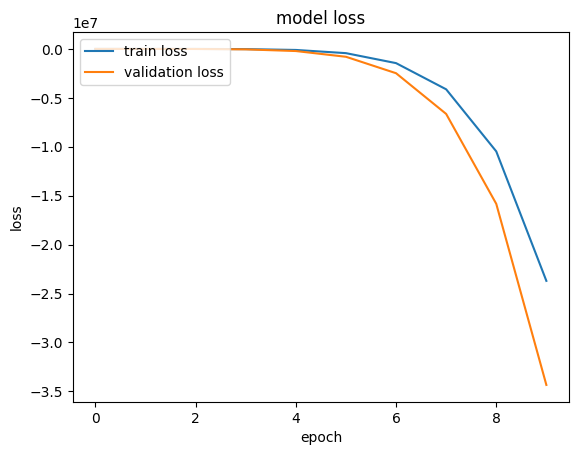

In [10]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


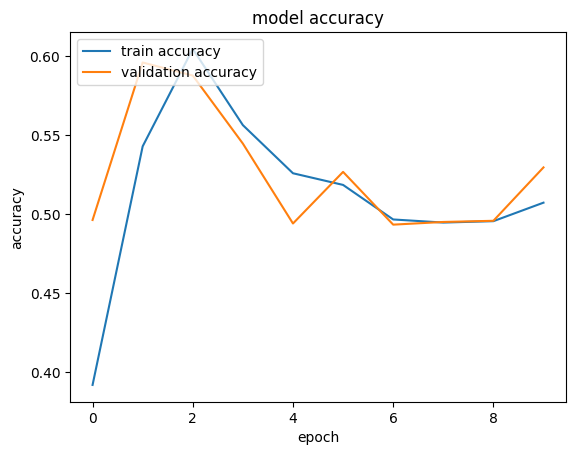

In [11]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='upper left')
plt.show()

### **Conclusion**

The convolutional decoder model which uses convolutional layers for denoising the images is built and deployed 